In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
!pip install num2words
import num2words
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import math
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.layers.convolutional import Conv1D 
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#step 1- Mount your Google Drive to Collaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df= pd.read_csv('/content/drive/MyDrive/ABSA_MS_Research_Project/roberta_labelling.csv')

In [4]:
df.head()
len(df)

10003

Split into train and test



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


POSITIVE    6517
NEGATIVE    3486
Name: aspect_Polarity, dtype: int64

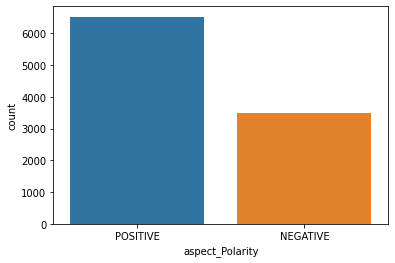

In [5]:
sns.countplot(df.aspect_Polarity)
df.aspect_Polarity.value_counts()

In [6]:
 from sklearn.utils import shuffle
 def cap_data(df):
    cap_df= pd.DataFrame()
    cap_df = df[df['aspect_Polarity']== 'POSITIVE'][:4000]
    cap_df = cap_df.append(df[df['aspect_Polarity']== 'NEGATIVE'])
    cap_df = shuffle(cap_df)   
    return(cap_df)

df = cap_data(df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


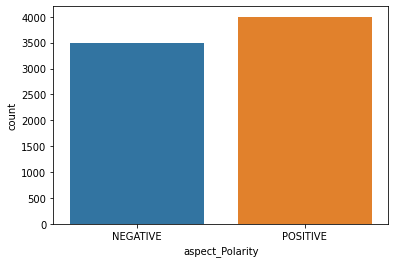

In [7]:
import seaborn as sns
sns.countplot(df.aspect_Polarity)

In [8]:
df.aspect_Polarity.value_counts()

POSITIVE    4000
NEGATIVE    3486
Name: aspect_Polarity, dtype: int64

In [9]:
df.head()

,Unnamed: 0,Review,Rating,clean_reviews,sentence_reviews,room,staff,location,service,food,cosine_pred_category,cosine_pred_percentage,aspect_Polarity,asp_score
6203,6203,"ok hotel booked hotel priceline got, nice hote...",3,"ok hotel booked hotel priceline got, nice hote...",nice hotel price paid one hundred.zero nothin...,0.311197,0.152908,0.183006,0.224081,0.141563,room,0.311197,NEGATIVE,0.999479
8068,8068,poor customer relations 15th visit french quar...,1,poor customer relations fifteenth visit french...,photos dent video manager looking damage taken,0.031860,0.041555,0.065781,0.051153,0.026077,location,0.065781,NEGATIVE,0.997022
1263,1263,"trust great, just returned trip seattle, booke...",5,"trust great, returned trip seattle, booked may...",returned trip seattle,0.128753,0.108559,0.228898,0.129813,0.067529,location,0.228898,POSITIVE,0.998352
1560,1560,"miss, stayed hotel friend weekend 19th-21st se...",1,"miss, stayed hotel friend weekend nineteenth t...",air conditioning work turn produced worrying ...,0.112835,0.117743,-0.012036,0.113548,0.041393,staff,0.117743,NEGATIVE,0.999464
4960,4960,sunshine just returned week trip dominican rep...,3,sunshine returned week trip dominican rep. say...,order chicken wing appetizers overall food go...,0.167873,0.164988,0.130948,0.215958,0.404549,food,0.404549,POSITIVE,0.998722


In [10]:
# labelling pos as 1 and neg as 0
def making_label(st):
    if(st=='POSITIVE'):
      return 1
    else:
        return 0
    
df['label'] = df['aspect_Polarity'].apply(making_label)
print(df.shape)

(7486, 15)


In [11]:
# conversion of input data
df = pd.DataFrame({
    'text': df['sentence_reviews'].replace(r'\n', ' ', regex=True),
    'label': df['label']
})


In [12]:
print(df.shape)
X = df['text']
y = df['label']


(7486, 2)


In [13]:
df.head()

,text,label
6203,nice hotel price paid one hundred.zero nothin...,0
8068,photos dent video manager looking damage taken,0
1263,returned trip seattle,1
1560,air conditioning work turn produced worrying ...,0
4960,order chicken wing appetizers overall food go...,1


**Train_Test_Split**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5988,)
(1498,)
(5988,)
(1498,)


In [15]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

**Preparing the Embedding Layer**

In [16]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
vocab_size

6893

**LSTM**

In [19]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train','test'], loc = 'upper left')
  plt.show()

In [20]:
BATCH_SIZE = 256

def evaluate(model,X_test,y_test):
    y_hat = model.predict(X_test,batch_size = BATCH_SIZE)
    print(y_hat)
    y_hat = (y_hat >= 0.5).astype(np.float32)
    print('rectified y_hat')
    print(y_hat)
    print(y_hat.shape)
    report = classification_report(y_test, y_hat)
    return report

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=maxlen),
    tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(maxlen, vocab_size)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          689300    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1)                 12801     
                                                                 
Total params: 819,349
Trainable params: 819,349
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 3
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=39)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.2,batch_size = BATCH_SIZE, verbose=2,callbacks=[callback])


Epoch 1/3
19/19 - 4s - loss: 0.6885 - accuracy: 0.5520 - val_loss: 0.6807 - val_accuracy: 0.5927 - 4s/epoch - 225ms/step
Epoch 2/3
19/19 - 0s - loss: 0.5621 - accuracy: 0.7146 - val_loss: 0.5085 - val_accuracy: 0.7462 - 288ms/epoch - 15ms/step
Epoch 3/3
19/19 - 0s - loss: 0.3226 - accuracy: 0.8649 - val_loss: 0.5244 - val_accuracy: 0.7646 - 277ms/epoch - 15ms/step


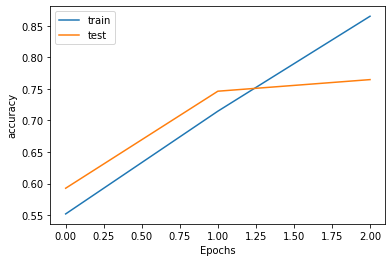

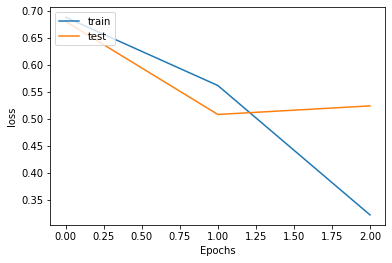

[[0.1676071 ]
 [0.53317946]
 [0.47711635]
 ...
 [0.19156206]
 [0.12907065]
 [0.6037816 ]]
rectified y_hat
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
(1498, 1)
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       678
           1       0.82      0.78      0.80       820

    accuracy                           0.78      1498
   macro avg       0.78      0.79      0.78      1498
weighted avg       0.79      0.78      0.78      1498



In [23]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

report = evaluate(model,X_test,y_test)
print(report)

Hyperparameters Optimization

In [24]:
def create_model(batch_size, vocab_size, embedding_dim, maxlen):
    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(maxlen, embedding_dim)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [25]:
 # Parameter grid for grid search
param_grid = dict(batch_size=[64, 128, 256],
                      vocab_size=[vocab_size],
                      embedding_dim=[100],
                      maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                            epochs=3,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", grid_result.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_result.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_result.best_params_)
test_accuracy

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          689300    
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          117248    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 819,349
Trainable params: 819,349
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
__________________________

0.7883844971656799

In [26]:
def evaluate_cv(model,X_test,y_test):
    y_hat = model.predict(X_test)
    print(y_hat)
    print(y_hat.shape)
    report = classification_report(y_test, y_hat)
    return report

In [27]:
report = evaluate_cv(grid_result,X_test,y_test)
print(report)

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]
(1498, 1)
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       678
           1       0.80      0.82      0.81       820

    accuracy                           0.79      1498
   macro avg       0.79      0.78      0.79      1498
weighted avg       0.79      0.79      0.79      1498



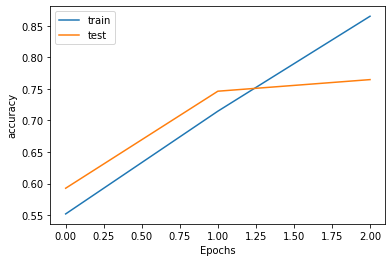

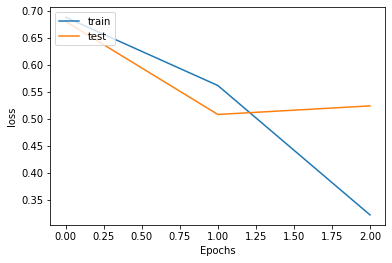

In [28]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
